# Imports

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Plot the image

In [9]:
def plot_image(image):
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.axis(False)
    plt.show()

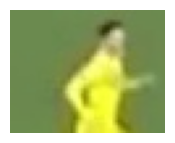

In [18]:
IMG_PATH = '../output_videos/player_cropped.jpg'

img = cv2.imread(IMG_PATH)

# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_top = img[0: img.shape[0]//2, :]

plot_image(img_top)

# Clustering

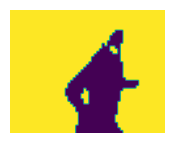

In [21]:
img_top_reshape = img_top.reshape(-1, 3)

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(img_top_reshape)

# Get Cluster Labels
labels = kmeans.labels_

# Reshape the labels into the image shape
cluster_img = labels.reshape(img_top.shape[0], img_top.shape[1])

plot_image(cluster_img)

Distinguish Player Cluster from Background

Player cluster index: 0
The color of the players jersey: (226, 231, 85): 


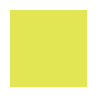

In [22]:
# Most frequent cluster of the corners should be the background cluster
corners = [cluster_img[0, 0], cluster_img[0, -1], cluster_img[-1, 0], cluster_img[-1, -1]]
bg_cluster = max(set(corners), key=corners.count)

# The other cluster is a player cluster
player_cluster = 1-bg_cluster

print(f'Player cluster index: {player_cluster}')

jersey_color = kmeans.cluster_centers_[player_cluster]

print(f'The color of the players jersey: ({ ", ".join([str(round(x)) for x in jersey_color])}): ')

plt.figure(figsize=(1,1))
plt.imshow([[tuple([x / 255. for x in jersey_color])]])
plt.axis(False)
plt.show()